In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import json
import re

import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports for preprocessing
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Load the test data
test_data = pd.read_csv('sanitizedTestNov30.csv', delimiter=',', header=None)
test_data.columns = ['eventid', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'session', 
                     'protocol', 'version', 'hassh', 'hasshAlgorithms', 'message', 
                     'sensor', 'timestamp']

# Define malicious keywords and whitelist phrases as in the original code
malicious_keywords = ['failed', 'whoami', 'uname', 'chattr', 'cat', ' rm', '.ssh', 'authorized_keys',
                      'grep', 'chmod', 'curl', 'not found', 'mkdir', '/bin/', '/tmp/', 'sshd', '.sh', 
                      'ssh-rsa', 'ps', 'crontab', 'uptime', 'ifconfig', 'cpuinfo', 'df', 'chpasswd', 
                      'free', 'pkill', 'pgrep', 'admin']

whitelist_phrases = ["SSH client hassh fingerprint", "New connection"]

# Define the function to flag malicious messages
def flag_malicious(message, whitelist_phrases, malicious_keywords):
    # Convert message to lowercase for case-insensitive matching
    message = message.lower()
    
    # Skip messages that contain any whitelisted phrases
    if any(phrase.lower() in message for phrase in whitelist_phrases):
        return 0
    
    #Ignore successful login attempts
    login_pattern = r'login attempt \[[^\]]+\] succeeded'
    if re.search(login_pattern, message):
        return 0

    # Check for malicious keywords
    if any(keyword in message for keyword in malicious_keywords):
        return 1
    
    # Check for failed login attempts
    failed_login_pattern = r'login attempt \[[^\]]+\] failed'
    if re.search(failed_login_pattern, message):
        return 1
    
    return 0

# Create a target column based on the presence of malicious keywords in the 'message' column
test_data['attack'] = test_data['message'].apply(flag_malicious, whitelist_phrases=whitelist_phrases, malicious_keywords=malicious_keywords)

# Keep only selected columns
test_data = test_data[['message', 'hasshAlgorithms', 'eventid', 'protocol', 'attack']]

In [2]:
# Initialize the LabelEncoder to encode categorical columns
le = LabelEncoder()

# Encode categorical columns (hasshAlgorithms, eventid, protocol)
test_data['hasshAlgorithms'] = le.fit_transform(test_data['hasshAlgorithms'])
test_data['eventid'] = le.fit_transform(test_data['eventid'])
test_data['protocol'] = le.fit_transform(test_data['protocol'])

# Separate features (X) and labels (y)
X_test = test_data.drop(['attack', 'message'], axis=1)
y_test = test_data['attack']

# Initialize StandardScaler to scale feature data
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Load the saved models
with open('finalized_model_XGB.sav', 'rb') as file:
    model_xgb = pickle.load(file)

with open('finalized_model_SVM.sav', 'rb') as file:
    model_svm = pickle.load(file)

with open('finalized_model_NN.sav', 'rb') as file: 
    model_nn = pickle.load(file)

with open('finalized_model_Voting.sav', 'rb') as file:
    voting_clf = pickle.load(file)

In [3]:
# Make predictions on the test set using each model
y_pred_xgb = model_xgb.predict(X_test_scaled)
y_pred_svm = model_svm.predict(X_test_scaled)
y_pred_nn = model_nn.predict(X_test_scaled) 
y_pred_voting = voting_clf.predict(X_test_scaled)

# Evaluate the models on the test data
print("XGBoost Classifier Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

print("SVM Classifier Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

print("Neural Network (MLPClassifier) Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(confusion_matrix(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))

print("Voting Classifier (Soft) Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print(confusion_matrix(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))

XGBoost Classifier Evaluation:
Accuracy: 0.8140
[[24348  1269]
 [ 4761  2042]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     25617
           1       0.62      0.30      0.40      6803

    accuracy                           0.81     32420
   macro avg       0.73      0.63      0.65     32420
weighted avg       0.79      0.81      0.79     32420

SVM Classifier Evaluation:
Accuracy: 0.9772
[[24908   709]
 [   31  6772]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     25617
           1       0.91      1.00      0.95      6803

    accuracy                           0.98     32420
   macro avg       0.95      0.98      0.97     32420
weighted avg       0.98      0.98      0.98     32420

Neural Network (MLPClassifier) Evaluation:
Accuracy: 0.7662
[[18903  6714]
 [  866  5937]]
              precision    recall  f1-score   support

           0       0.96      0.74      0.83   

In [4]:
# Reload the original test data from the CSV file
original_test_data = pd.read_csv('sanitizedTestNov30.csv', delimiter=',', header=None)
original_test_data.columns = ['eventid', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'session', 
                               'protocol', 'version', 'hassh', 'hasshAlgorithms', 'message', 
                               'sensor', 'timestamp']

# Align the predictions with the original data length
if len(y_pred_voting) != len(original_test_data):
    raise ValueError("Length mismatch: Predictions do not align with original_test_data.")

# Add predictions from the Voting Classifier as a new column 'attack' in the original data
original_test_data['attack'] = y_pred_voting

# Convert the dataframe to a JSON format
test_data_with_voting_json = original_test_data[['eventid', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 
                                                 'session', 'protocol', 'message', 'sensor', 'timestamp', 
                                                 'attack']].to_json(orient='records', lines=True)

# Save the JSON to a file
with open('votingClassifier_Predictions.json', 'w') as json_file:
    json_file.write(test_data_with_voting_json)

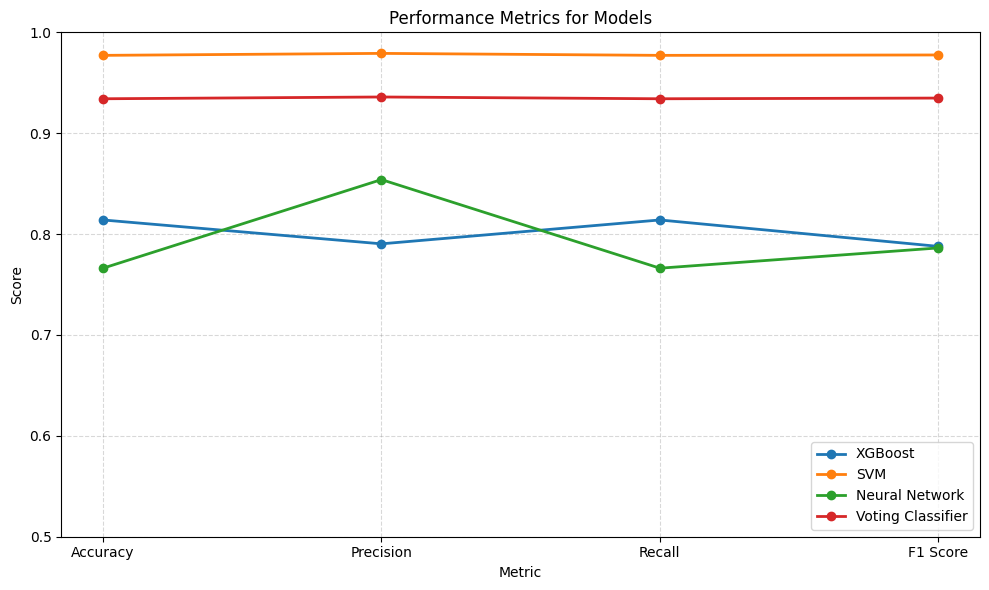

In [5]:
# Initialize the figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Only one subplot

# Make predictions on the test set using each model
y_true = y_test 
y_pred_xgb = model_xgb.predict(X_test_scaled) 
y_pred_svm = model_svm.predict(X_test_scaled)  
y_pred_nn = model_nn.predict(X_test_scaled)   
y_pred_voting = voting_clf.predict(X_test_scaled)

# 1. Performance Metrics (Accuracy, Precision, Recall, F1 Score) for each model
metrics = {
    'Model': ['XGBoost', 'SVM', 'Neural Network', 'Voting Classifier'],
    'Accuracy': [
        accuracy_score(y_true, y_pred_xgb), 
        accuracy_score(y_true, y_pred_svm), 
        accuracy_score(y_true, y_pred_nn), 
        accuracy_score(y_true, y_pred_voting)
    ],
    'Precision': [
        precision_score(y_true, y_pred_xgb, average='weighted'),
        precision_score(y_true, y_pred_svm, average='weighted'),
        precision_score(y_true, y_pred_nn, average='weighted'),
        precision_score(y_true, y_pred_voting, average='weighted')
    ],
    'Recall': [
        recall_score(y_true, y_pred_xgb, average='weighted'),
        recall_score(y_true, y_pred_svm, average='weighted'),
        recall_score(y_true, y_pred_nn, average='weighted'),
        recall_score(y_true, y_pred_voting, average='weighted')
    ],
    'F1 Score': [
        f1_score(y_true, y_pred_xgb, average='weighted'),
        f1_score(y_true, y_pred_svm, average='weighted'),
        f1_score(y_true, y_pred_nn, average='weighted'),
        f1_score(y_true, y_pred_voting, average='weighted')
    ]
}

# Create a DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics)

# List of metrics for the x-axis
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plot the metrics for each model
for model in metrics_df['Model']:
    ax.plot(metrics_list, 
            metrics_df.loc[metrics_df['Model'] == model, metrics_list].values.flatten(),
            label=model, marker='o', linestyle='-', linewidth=2)

# Set the y-axis limit to range from 0 to 1
ax.set_ylim(0.5, 1)

# Adding titles and labels for performance metrics
ax.set_title('Performance Metrics for Models')
ax.set_xlabel('Metric')
ax.set_ylabel('Score')

# Move the legend to the bottom right
ax.legend(loc='lower right')

# Add faded grid lines
ax.grid(True, linestyle='--', color='gray', alpha=0.3)  # Adjust alpha for faded lines

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()

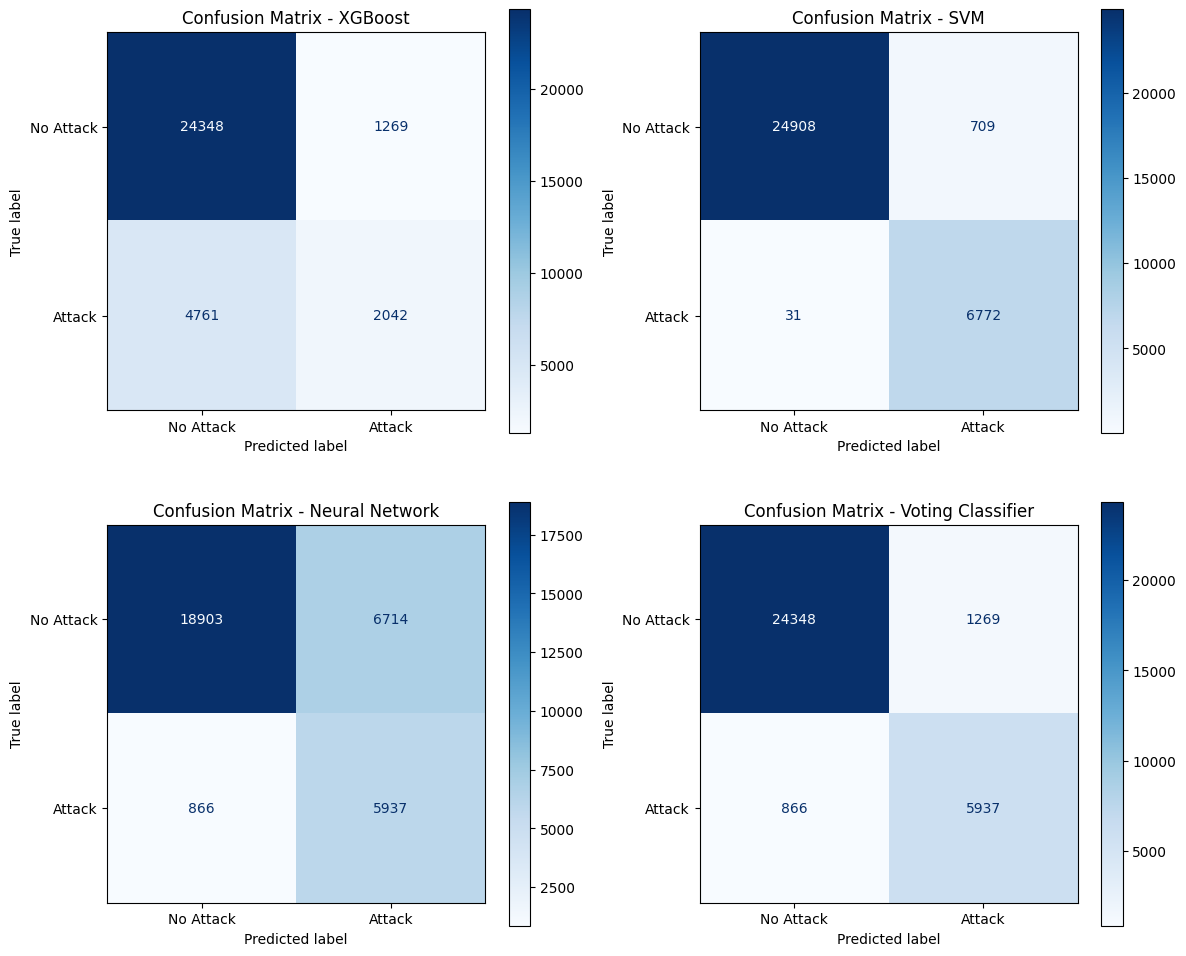

In [6]:
# Generate predictions using each model
y_pred_xgb = model_xgb.predict(X_test_scaled)
y_pred_svm = model_svm.predict(X_test_scaled)
y_pred_knn = model_nn.predict(X_test_scaled)
y_pred_voting = voting_clf.predict(X_test_scaled)

# Create confusion matrices for each model
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_mlp = confusion_matrix(y_test, y_pred_knn)
cm_voting = confusion_matrix(y_test, y_pred_voting)

# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid for 4 models
axes = axes.flatten()

# Define model names for the titles
model_names = ['XGBoost', 'SVM', 'Neural Network', 'Voting Classifier']
cm_list = [cm_xgb, cm_svm, cm_mlp, cm_voting]

# Plot each confusion matrix
for i, cm in enumerate(cm_list):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Attack", "Attack"])
    disp.plot(cmap="Blues", values_format="d", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - {model_names[i]}")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot with all confusion matrices
plt.show()


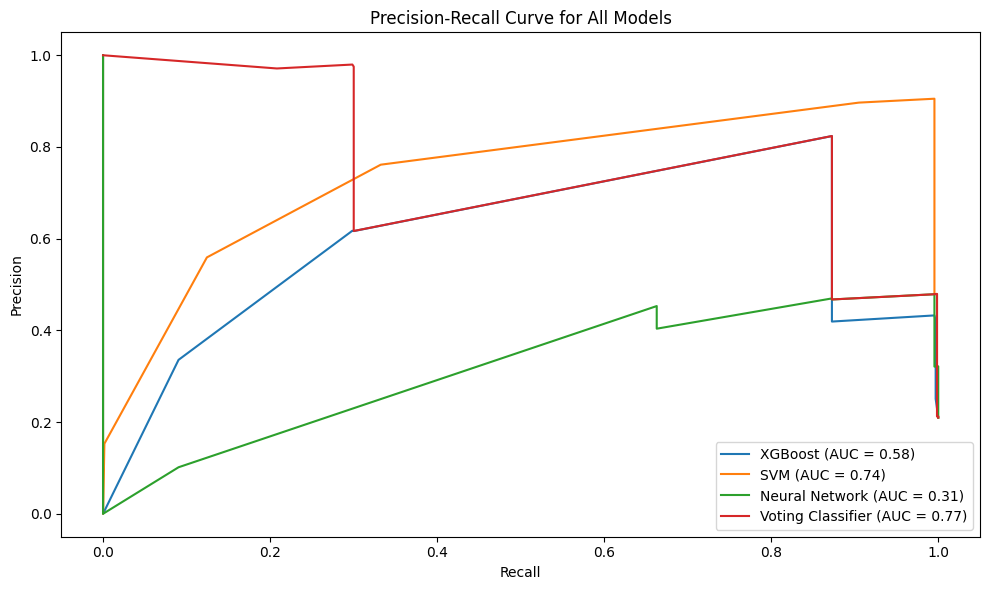

In [7]:
models = [model_xgb, model_svm, model_nn, voting_clf]
model_names = ['XGBoost', 'SVM', 'Neural Network', 'Voting Classifier']

plt.figure(figsize=(10, 6))

for model, name in zip(models, model_names):
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Get probability scores for positive class
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})')

plt.title('Precision-Recall Curve for All Models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

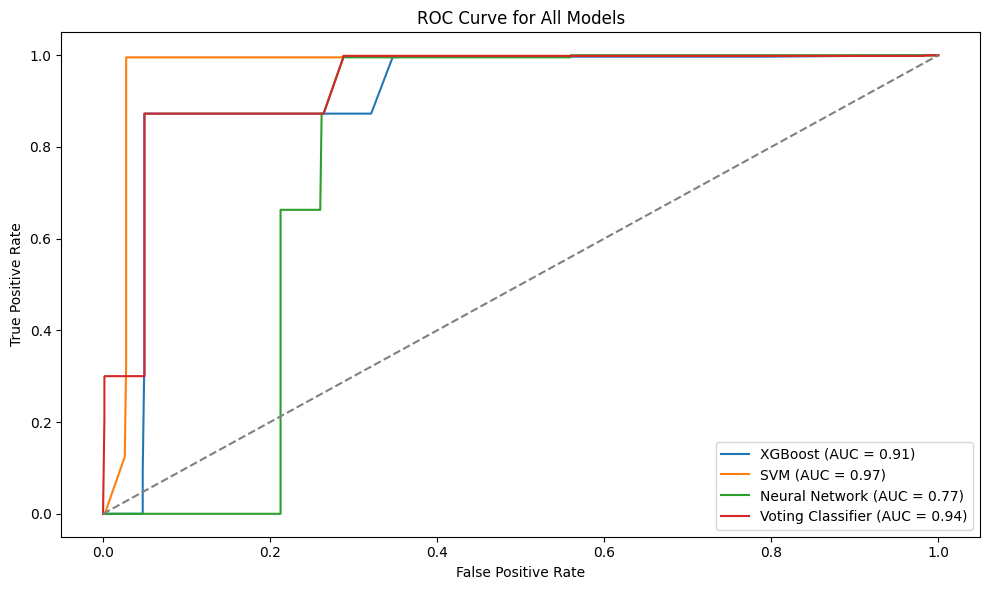

In [8]:
models = [model_xgb, model_svm, model_nn, voting_clf]
model_names = ['XGBoost', 'SVM', 'Neural Network', 'Voting Classifier']

plt.figure(figsize=(10, 6))

for model, name in zip(models, model_names):
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Get probability scores for positive class
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line
plt.title('ROC Curve for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.tight_layout()
plt.show()